# Implementing Transformer Models
## Practical IX
Carel van Niekerk & Hsien-Chin Lin

15.12.2025-09.01.2026

---

In this practical we will implement the training script train the transformer model.

### 1. Essentials of the training script

In the training script the prepared dataset is used to train a model instance. Before training the model, the instance should be initialised, a dataloader should be created from the dataset and the loss function, optimiser and learning rate scheduler should be initialised. 

#### 1.1. Dataloaders

The dataloader is a pytorch class that is used to load data from the dataset in batches. The dataloader is initialised with the dataset and the batch size. The dataloader is then used to iterate over the dataset in batches. The dataloader is used in the training loop to load the data for each batch.

The dataloader for the training data is initialised as follows:

```python
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
```

#### 1.2. Training the model

Once the model, dataloader and loss function are initialised, the model can be trained. The training loop iterates over the batches in the dataloader and performs the following steps:

1. Load the data for the batch.
2. Perform a forward pass through the model.
3. Calculate the loss.
4. Perform a backward pass through the model.
5. Update the model parameters.
6. Update the learning rate.
7. Repeat for the next batch.
8. Repeat for the next epoch.

# Exercises

1. Initialise a small version of your transformer model (do not use more than 4 layers and 64 hidden units unless you have access to sufficient compute).
2. Initialise the dataloader using the dataset class from practical 5.
3. Initialise the loss function (cross entropy loss), optimiser and learning rate scheduler.
4. Implement the training loop.
5. Train the model for 5 epochs and ensure that loss decreases for both the training and validation sets of the dataset. You can use a small randomly selected subset of the training data to speed up training.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import sys
sys.path.append('d:/Code/implementingtransformers')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from datasets import load_dataset
import random

from transformer_project.modelling import Transformer, TransformerLRScheduler, get_optimizer
from transformer_project.data_cleaning import clean_dataset
from transformer_project.dataset import TranslationDataset, collate_fn
from transformer_project.tokenizer_wrapper import TranslationTokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

d:\anaconda3\envs\transformer\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
# Load and prepare a small subset of the dataset
print("Loading dataset...")
dataset = load_dataset("wmt17", "de-en", split="train[:5000]")
val_dataset = load_dataset("wmt17", "de-en", split="validation[:500]")

print("Cleaning dataset...")
train_data = clean_dataset(dataset, min_len=3, max_len=32)
val_data = clean_dataset(val_dataset, min_len=3, max_len=32)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")

Loading dataset...


C:\Users\Abtin\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Abtin\.cache\huggingface\hub\datasets--wmt17. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download

Cleaning dataset...
Training samples: 3568
Validation samples: 430


In [3]:
# Train tokenizer on the corpus
print("Training tokenizer...")
all_texts = [item['de'] for item in train_data] + [item['en'] for item in train_data]
tokenizer = TranslationTokenizer(vocab_size=8000)
tokenizer.train(all_texts, save_dir="./tokenizer_cache")

print(f"Vocabulary size: {tokenizer.vocab_size_actual}")

Training tokenizer...
Vocabulary size: 8000


In [4]:
# Create datasets and dataloaders
train_dataset = TranslationDataset(train_data, tokenizer, max_len=32)
val_dataset_obj = TranslationDataset(val_data, tokenizer, max_len=32)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset_obj, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print(f"Training batches: {len(train_dataloader)}")
print(f"Validation batches: {len(val_dataloader)}")

Training batches: 112
Validation batches: 14


In [5]:
# Initialize small transformer model
model = Transformer(
    vocab_size=tokenizer.vocab_size_actual,
    d_model=64,
    n_heads=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=256,
    dropout=0.1,
    max_len=64,
    pad_idx=tokenizer.pad_token_id
).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: {num_params:,}")

Model parameters: 743,936


In [6]:
# Initialize loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = get_optimizer(model, lr=1.0, weight_decay=0.01)
scheduler = TransformerLRScheduler(optimizer, d_model=64, warmup_steps=500)

print("Loss function: CrossEntropyLoss")
print("Optimizer: AdamW with decoupled weight decay")
print("Scheduler: Transformer warmup scheduler")

Loss function: CrossEntropyLoss
Optimizer: AdamW with decoupled weight decay
Scheduler: Transformer warmup scheduler


In [7]:
def train_epoch(model, dataloader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    
    for batch in dataloader:
        src = batch['src_ids'].to(device)
        tgt = batch['tgt_ids'].to(device)
        src_mask = batch['src_mask'].to(device)
        tgt_mask = batch['tgt_mask'].to(device)
        
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]
        tgt_mask_input = tgt_mask[:, :-1]
        
        optimizer.zero_grad()
        logits = model(src, tgt_input, src_mask, tgt_mask_input)
        
        loss = criterion(logits.reshape(-1, logits.size(-1)), tgt_output.reshape(-1))
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            src = batch['src_ids'].to(device)
            tgt = batch['tgt_ids'].to(device)
            src_mask = batch['src_mask'].to(device)
            tgt_mask = batch['tgt_mask'].to(device)
            
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            tgt_mask_input = tgt_mask[:, :-1]
            
            logits = model(src, tgt_input, src_mask, tgt_mask_input)
            loss = criterion(logits.reshape(-1, logits.size(-1)), tgt_output.reshape(-1))
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

In [8]:
# Training loop
num_epochs = 5
train_losses = []
val_losses = []

print("Starting training...")
print("-" * 50)

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_dataloader, criterion, optimizer, scheduler, device)
    val_loss = evaluate(model, val_dataloader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    current_lr = scheduler.get_lr()[0]
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {current_lr:.6f}")

print("-" * 50)
print("Training complete!")

Starting training...
--------------------------------------------------
Epoch 1/5 | Train Loss: 6.4196 | Val Loss: 3.2496 | LR: 0.001263
Epoch 2/5 | Train Loss: 2.9919 | Val Loss: 2.9636 | LR: 0.002516
Epoch 3/5 | Train Loss: 2.5542 | Val Loss: 2.5951 | LR: 0.003768
Epoch 4/5 | Train Loss: 2.2640 | Val Loss: 2.5267 | LR: 0.005020
Epoch 5/5 | Train Loss: 2.1074 | Val Loss: 2.4762 | LR: 0.005278
--------------------------------------------------
Training complete!


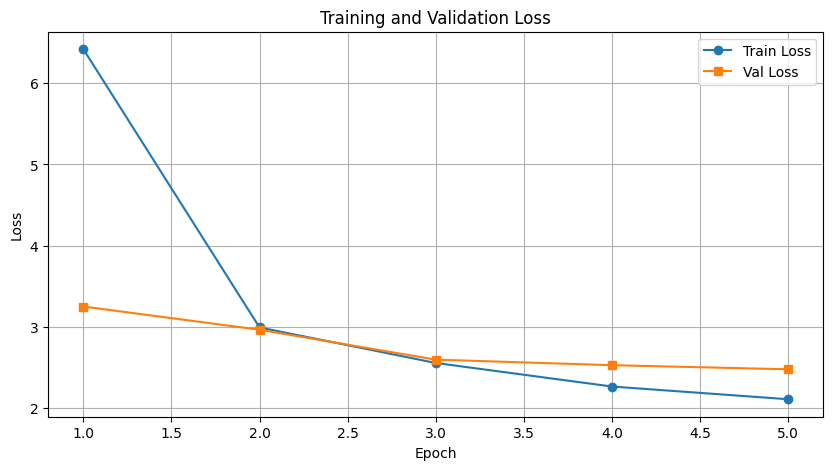


Final Train Loss: 2.1074
Final Val Loss: 2.4762


In [10]:
# Plot training curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nFinal Train Loss: {train_losses[-1]:.4f}")
print(f"Final Val Loss: {val_losses[-1]:.4f}")